In [7]:
using LinearAlgebra, Pkg, CUDA, Plots, OMEinsum, ProgressLogging, GellMannMatrices, Statistics, StatsBase, Revise, Zygote

In [8]:
using Qutee
using Qutee.QuantumInfo: kraus2liou, liou2pauliliou, liou2choi, liou2kraus, choi2kraus, fidelity
using Qutee.QuantumInfo.Optimization: kraus2stiefel, stiefel2kraus

# Random Benchmark

In the following, we generate a random quantum channel and obtain the true data measurements one would obtain from an experiment.

We then use this data to fit our own channel via Riemannian optimization. We look at the following factors:
- Kraus rank of our channel
- Access to only a fraction of data ν
- The fidelity of our quantum channel via Choi representation

In [9]:
N = 3

# Random Channel
K_r = QuantumInfo.rand_channel(CuArray, 4^N, 2^N)

# Express as a a Choi matrix to compute Fidelity later
L = K_r |> kraus2liou |> liou2choi |> Array

# Generate a basis
basis = gellmann(Matrix{ComplexF32}, 2^N; normalize=true, skip_identity=true);
probes_mat = eigvecs.(basis) |> stack;
probes_mat_v = reshape(probes_mat, (size(probes_mat)[1], 1, size(probes_mat)[2], size(probes_mat)[3]));
probes_rho = stack([a * a' for a in eachslice(probes_mat_v, dims=(3, 4))]) |> cu;
probes_rho = reshape(probes_rho, (size(probes_rho, 1), size(probes_rho, 1), size(probes_rho, 3) * size(probes_rho, 4)))
basis_cu = probes_rho;

In [10]:
function apply_batch(op, rhos)
    op_conj = conj(op)
    @ein c[i, k, n, m] := rhos[i, j, n] * op_conj[k, j, m]
    @ein d[i, k, n] := op[i, j, m] * c[j, k, n, m]
    return d
end

function measure_batch(meas, rho)
    @ein c[i, k, n, m] := meas[i, j, m] * rho[j, k, n]
    @ein out[n, m] := c[i, i, n, m]
    return out |> real
end

measure_batch (generic function with 1 method)

In [11]:
ideal = apply_batch(K_r, probes_rho);
ideal_data = measure_batch(basis_cu, ideal)

504×504 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 0.122442  0.10889   0.135505  0.11393   …  0.11393   0.127403  0.135371
 0.120492  0.126493  0.133675  0.153901     0.153901  0.11081   0.112139
 0.138162  0.127121  0.15916   0.101376     0.101376  0.134001  0.115583
 0.101362  0.135584  0.12881   0.106022     0.106022  0.133825  0.115209
 0.102741  0.108783  0.138413  0.107411     0.107411  0.139049  0.137938
 0.132062  0.154322  0.115127  0.118201  …  0.118201  0.148848  0.110059
 0.12341   0.107039  0.130431  0.111365     0.111365  0.141611  0.11838
 0.123935  0.128446  0.118003  0.11217      0.11217   0.114693  0.13972
 0.115516  0.127057  0.133894  0.11061      0.11061   0.122762  0.135745
 0.120492  0.126493  0.133675  0.153901     0.153901  0.11081   0.112139
 ⋮                                       ⋱                      
 0.12085   0.147003  0.115471  0.109928  …  0.109928  0.151969  0.10541
 0.12341   0.107039  0.130431  0.111365     0.111365  0.141611  0.11838
 0.119578  

## Optimization

We define the following:

- Loss function
- Model function which takes a channel and provides limited output data 
- Optimize function which performs ADAM optimization

In [12]:
function loss(K, ideal_data, basis_cu, probes)

    rho_prime = apply_batch(K, probes)
    data = measure_batch(basis_cu, rho_prime)

    result = ideal_data - data

    sum(result .^ 2)
end

function model(K, i, j)
    basis = basis_cu[:, :, i]
    probes = probes_rho[:, :, j]

    probe_prime = apply_batch(K, probes)
    data = measure_batch(basis, probe_prime)
    return data
end

function model_partial(K, probes, basis)
    probe_prime = apply_batch(K, probes)
    data = measure_batch(basis, probe_prime)
    return data
end

model_partial (generic function with 1 method)

In [13]:
function optimize(k, ϵ, ν)
    """
    The following performs an optimization by:
    - Selecting only a fraction ν of data
    - Splitting the data into batches (data_len/3)
    - Performing a step with ADAM optimizer
    """
    adam = QuantumInfo.Optimization.AdamCayley(QuantumInfo.rand_channel(CuArray, k, 2^N); l=0.2, β1=0.95, β2=0.999)

    # Extract a fraction of data
    le = size(basis_cu, 3)
    c1 = sample(1:le, floor(sqrt(ν) * le) |> Int64; replace=false)
    c2 = sample(1:le, floor(sqrt(ν) * le) |> Int64; replace=false)
    basis = basis_cu[:, :, c1]
    probes = probes_rho[:, :, c2]

    data = model_partial(K_r, probes, basis)

    # Add some noise
    data += ϵ * CUDA.randn(Float32, size(data))

    train_loss = []

    batch_size = floor(size(basis, 3) / 3) |> Int64
    for epoch in 1:50
        if epoch > 30
            # adam.l = 0.2
            adam.β_1 = 0.99
        end
        for i in 1:30
            le = size(basis, 3)
            c1 = sample(1:le, batch_size; replace=false)
            c2 = sample(1:le, batch_size; replace=false)
            function f(K)
                out = model_partial(K, probes[:, :, c2], basis[:, :, c1])
                res = out - data[c2, c1]
                return sum(res .^ 2)
            end


            # Do the optimization step
            K = adam.X |> stiefel2kraus
            grad = Zygote.gradient(x -> f(x), K)[1]
            grad = kraus2stiefel(grad)

            QuantumInfo.Optimization.step!(adam, grad)
        end
        K = adam.X |> stiefel2kraus
        push!(train_loss, loss(K, data, basis, probes))
    end
    K = adam.X |> stiefel2kraus

    L_res = K |> kraus2liou |> liou2choi |> Array
    fid = fidelity(L_res, L) / 4^N
    return fid, train_loss, K
end

optimize (generic function with 1 method)

In [14]:
k_range = [1, 2, 4, 8, 16, 32, 64] # kraus ranks to test
ν_range = LinRange(0.2, 1, 20) # fraction of data to test

20-element LinRange{Float64, Int64}:
 0.2, 0.242105, 0.284211, 0.326316, …, 0.873684, 0.915789, 0.957895, 1.0

In [15]:
# Perform optimization

all_out = []
@progress for k in k_range
    for ν in ν_range
        all_fid = []
        for _ in 1:15
            fid, his, out_k = optimize(k, 0.001, ν)
            push!(all_fid, fid)
        end
        push!(all_out, mean(all_fid))
    end
end

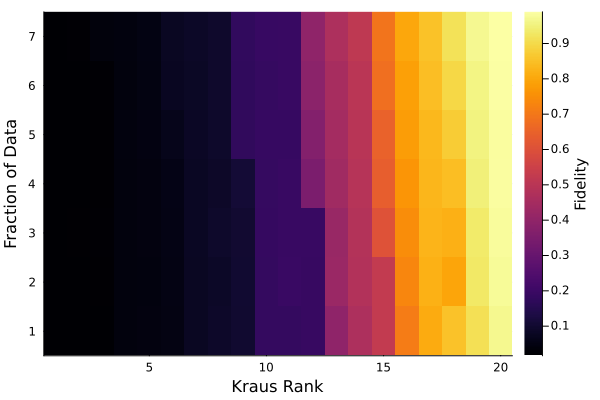

In [21]:
T = reshape(all_out, length(k_range), length(ν_range))
heatmap(T, xlabel="Kraus Rank", ylabel="Fraction of Data", colorbar_title="Fidelity", fmt =:png)